In [23]:
import pandas as pd
import numpy as np
import scipy.stats
import sqlite3
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings = pd.read_sql("""
    select
        author_id,
        podcast_id,
        rating,
        created_at,
        case when rating < 3 then 0
            when rating > 4 then 2
            else 1
        end as sentiment
    from reviews
""", sqlite3.connect("database.sqlite"))

podcasts = pd.read_sql("""
    select
        podcast_id,
        title
    from podcasts
""", sqlite3.connect("database.sqlite"))

categories = pd.read_sql("""
    select
        podcast_id,
        category
    from categories
""", sqlite3.connect("database.sqlite"))

In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004000 entries, 0 to 2003999
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   author_id   object
 1   podcast_id  object
 2   rating      int64 
 3   created_at  object
 4   sentiment   int64 
dtypes: int64(2), object(3)
memory usage: 76.4+ MB


In [4]:
ratings.head()

,author_id,podcast_id,rating,created_at,sentiment
0,F7E5A318989779D,c61aa81c9b929a66f0c1db6cbe5d8548,5,2018-04-24T12:05:16-07:00,2
1,F6BF5472689BD12,c61aa81c9b929a66f0c1db6cbe5d8548,5,2018-05-09T18:14:32-07:00,2
2,1AB95B8E6E1309E,ad4f2bf69c72b8db75978423c25f379e,1,2019-06-11T14:53:39-07:00,0
3,11BB760AA5DEBD1,ad4f2bf69c72b8db75978423c25f379e,5,2018-05-31T13:08:09-07:00,2
4,D86032C8E57D15A,ad4f2bf69c72b8db75978423c25f379e,5,2019-06-19T13:56:05-07:00,2


In [5]:
podcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109216 entries, 0 to 109215
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  109216 non-null  object
 1   title       109216 non-null  object
 2   slug        109216 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [6]:
podcasts.head()

,podcast_id,title,slug
0,a00018b54eb342567c94dacfb2a3e504,Scaling Global,scaling-global
1,a00043d34e734b09246d17dc5d56f63c,Cornerstone Baptist Church of Orlando,cornerstone-baptist-church-of-orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,Mystery: Dancing in the Dark,mystery-dancing-in-the-dark
3,a00071f9aaae9ac725c3a586701abf4d,KTs Money Matters,kts-money-matters
4,a000aa69852b276565c4f5eb9cdd999b,Speedway Soccer,speedway-soccer


In [7]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211243 entries, 0 to 211242
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  211243 non-null  object
 1   category    211243 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [8]:
categories.head()

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


In [59]:
_df = pd.merge(ratings, podcasts, on='podcast_id', how='inner')
df = pd.merge(_df, categories, on='podcast_id', how='inner')

In [66]:
len(df)

4388778

In [13]:
user_filter = ratings.groupby('author_id').count()
filt = 15
active_users = user_filter[user_filter['podcast_id'] > filt]
print(f"Number of users with more than {filt} ratings: {len(active_users)}")

Number of users with more than 15 ratings: 2354


In [14]:
active_users

,podcast_id,rating,created_at,sentiment
author_id,,,,
0009C2AB9F332A0,27,27,27,27
00384BC4052C5FB,22,22,22,22
00630C00727EEAA,16,16,16,16
00A20905E0BC081,18,18,18,18
00B3416D9E06E07,38,38,38,38
...,...,...,...,...
FEBE9256AEF0B00,16,16,16,16
FEDAE40E3E3EC9B,20,20,20,20
FEE08D8BD269202,26,26,26,26


In [15]:
print(f"Number of unique users: {df['author_id'].nunique()}")
print(f"Number of unique podcasts: {df['podcast_id'].nunique()}")
print(f"Number of unique categories: {df['category'].nunique()}")
print(f"Number of unique ratings: {df['rating'].nunique()}")
print(f"The unique ratings are: {sorted(df['rating'].unique())}")

Number of unique users: 1424262
Number of unique podcasts: 109216
Number of unique categories: 110
Number of unique ratings: 5
The unique ratings are: [1, 2, 3, 4, 5]


In [67]:
#Aggregate by podcast
agg_ratings = df.groupby('category').agg(mean_rating=('rating', 'mean'), 
                                    number_of_ratings= ('rating', 'count')).reset_index()

#Podcasts with greater than 2500 reviews
agg_ratings_GT500 = agg_ratings#[agg_ratings['number_of_ratings'] > 200]

In [68]:
agg_ratings_GT500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           110 non-null    object 
 1   mean_rating        110 non-null    float64
 2   number_of_ratings  110 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ KB


In [70]:
agg_ratings_GT500.sort_values(by='mean_rating', ascending=False)

,category,mean_rating,number_of_ratings
94,sports-rugby,4.987879,165
13,business-marketing,4.937790,27970
10,business-entrepreneurship,4.908728,77187
14,business-non-profit,4.900872,2522
95,sports-running,4.896383,5916
...,...,...,...
59,news,4.303669,173933
80,society-culture-documentary,4.301537,29280
64,news-politics,4.205059,46372
103,true-crime,4.176693,155473


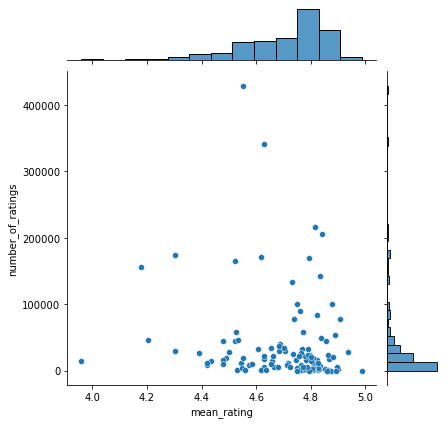

In [71]:
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT500)

In [24]:
df_GT500 = pd.merge(df, agg_ratings_GT500[['title']], on='title', how='inner')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4388778 entries, 0 to 4388777
Data columns (total 8 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   author_id   object
 1   podcast_id  object
 2   rating      int64 
 3   created_at  object
 4   sentiment   int64 
 5   title       object
 6   slug        object
 7   category    object
dtypes: int64(2), object(6)
memory usage: 301.4+ MB


In [26]:
df_GT500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4388778 entries, 0 to 4388777
Data columns (total 8 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   author_id   object
 1   podcast_id  object
 2   rating      int64 
 3   created_at  object
 4   sentiment   int64 
 5   title       object
 6   slug        object
 7   category    object
dtypes: int64(2), object(6)
memory usage: 301.4+ MB


In [27]:
df_U50_GT500 = pd.merge(df_GT500, active_users.reset_index()[['author_id']], on='author_id', how='inner')

In [28]:
df_U50_GT500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162522 entries, 0 to 162521
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   author_id   162522 non-null  object
 1   podcast_id  162522 non-null  object
 2   rating      162522 non-null  int64 
 3   created_at  162522 non-null  object
 4   sentiment   162522 non-null  int64 
 5   title       162522 non-null  object
 6   slug        162522 non-null  object
 7   category    162522 non-null  object
dtypes: int64(2), object(6)
memory usage: 11.2+ MB


In [29]:
print(f"Number of unique users: {df_U50_GT500['author_id'].nunique()}")
print(f"Number of unique podcasts: {df_U50_GT500['podcast_id'].nunique()}")
print(f"Number of unique ratings: {df_U50_GT500['rating'].nunique()}")
print(f"The unique ratings are: {sorted(df_U50_GT500['rating'].unique())}")

Number of unique users: 2354
Number of unique podcasts: 16279
Number of unique ratings: 5
The unique ratings are: [1, 2, 3, 4, 5]


In [30]:
#Create user-item matrix
matrix = df_U50_GT500.pivot_table(index='author_id', columns='title', values='rating')

In [31]:
matrix.head(10)

title,! Weird Rap Podcast !,"""The Other Woman Fantasy""",#MarketplaceInfluencer Tomi Shane Ng,#STRask,#SaintsTwitter Podcast,"(Less Than, Approximately, Greater Than)",...These Are Their Stories: The Law & Order Podcast,1 Year Daily Audio Bible,1 Year Daily Audio Bible Chronological,10 Minute Teacher Podcast,...,thebusinessholics,thriftycast,uncrEDIBLE,unofficials,upNXT: The Unofficial NXT Podcast,was that TMI?,ya:Oi,¿Quién Are We?,從前從前,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃
author_id,,,,,,,,,,,,,,,,,,,,,
0009C2AB9F332A0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00384BC4052C5FB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00630C00727EEAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00A20905E0BC081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00B3416D9E06E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01007307CABB68D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0115306BE6FE10E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012195210524AB8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012CE71A78801C4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,! Weird Rap Podcast !,"""The Other Woman Fantasy""",#MarketplaceInfluencer Tomi Shane Ng,#STRask,#SaintsTwitter Podcast,"(Less Than, Approximately, Greater Than)",...These Are Their Stories: The Law & Order Podcast,1 Year Daily Audio Bible,1 Year Daily Audio Bible Chronological,10 Minute Teacher Podcast,...,thebusinessholics,thriftycast,uncrEDIBLE,unofficials,upNXT: The Unofficial NXT Podcast,was that TMI?,ya:Oi,¿Quién Are We?,從前從前,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃
author_id,,,,,,,,,,,,,,,,,,,,,
0009C2AB9F332A0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00384BC4052C5FB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00630C00727EEAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00A20905E0BC081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00B3416D9E06E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#Similarity matrix using the Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head(10)

author_id,0009C2AB9F332A0,00384BC4052C5FB,00630C00727EEAA,00A20905E0BC081,00B3416D9E06E07,01007307CABB68D,0115306BE6FE10E,012195210524AB8,012CE71A78801C4,013D5301F9C8928,...,FE4DFAD411BFF31,FE532AED5E1E44E,FE71127866421D7,FEAA538244E72EE,FEB9F4D6A87E1A9,FEBE9256AEF0B00,FEDAE40E3E3EC9B,FEE08D8BD269202,FEE5129BCE0E812,FF8C787F12AA8D1
author_id,,,,,,,,,,,,,,,,,,,,,
0009C2AB9F332A0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00384BC4052C5FB,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00630C00727EEAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00A20905E0BC081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00B3416D9E06E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01007307CABB68D,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0115306BE6FE10E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012195210524AB8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012CE71A78801C4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Similarity matrix using the cosine simmilarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0)) 

In [43]:
#Pick a user ID
picked_userid = 'F197F111FE42309'

user_similarity.drop(index=picked_userid, inplace=True)

user_similarity.head()

KeyError: "['F197F111FE42309'] not found in axis"

In [47]:
#Number of similar users
n = 50

#User similarity threshold
user_similarity_threhold = 0.3

#Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid] >= user_similarity_threhold][picked_userid].sort_values(ascending=False).head(n)

print(f"Similar users for {picked_userid} are", similar_users)

Similar users for F197F111FE42309 are author_id
1CD0E763463A43A    1.000000
25DE4EDD6E0E1C4    1.000000
7BBDEA4B71A88CB    1.000000
41C4C390BF9E7C8    1.000000
8DC33AA7300EE6A    1.000000
AE4F8F297034DA8    1.000000
A2FF4547117F0AB    1.000000
AA8BD42078E6D58    1.000000
ABE0553684B8D2C    1.000000
ADE32C2560C3C7B    1.000000
B7B64CDAD67B8A5    1.000000
B6C3E0107701D30    1.000000
CCA8F6C77A2C4B9    1.000000
D94A87E048774A5    1.000000
EF1568116595AA4    1.000000
EFB5FFA5447C81E    1.000000
2153A75F0CDE91D    1.000000
F7C1EB88BDCEAC3    1.000000
7F3F727D387F409    1.000000
7D2AABBED0919C2    1.000000
273F49654E2D128    1.000000
5D2BF4DA821995E    1.000000
289E8336AA7041A    1.000000
39F3B83D39ED47A    0.990593
83DB605686DB933    0.984141
C02E8F4828EF09F    0.984128
276893F5375852A    0.981112
D5728E3B4AB0335    0.958950
F797F8E301E2DD7    0.923800
C5A59755F7CF67C    0.907428
A274268660DACE1    0.896258
9CC21A9CFF67761    0.856506
BA11D0982994A9F    0.721649
D0C034CBF1267CD    0.636364


In [48]:
#Podcasts that the target user listened to
picked_userid_podcasts = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_podcasts

title,Bedtime Explorers,Greeking Out from National Geographic Kids,Hank the Cowdog,Highlights Hangout,Listen Out Loud with The Loud House,Live from Mount Olympus,Pants on Fire,Smash Boom Best,Story Pirates,Wow in the World
author_id,,,,,,,,,,
F197F111FE42309,-0.881548,0.118452,0.118452,0.118452,0.118452,0.118452,0.118452,-0.024405,0.076786,0.118452


In [49]:
picked_userid_ratings = matrix[matrix.index == picked_userid].dropna(axis=1, how='all')
picked_userid_ratings

title,Bedtime Explorers,Greeking Out from National Geographic Kids,Hank the Cowdog,Highlights Hangout,Listen Out Loud with The Loud House,Live from Mount Olympus,Pants on Fire,Smash Boom Best,Story Pirates,Wow in the World
author_id,,,,,,,,,,
F197F111FE42309,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.857143,4.958333,5.0


In [50]:
#podcasts that similar users listened to
similar_user_podcasts = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_podcasts

title,ASMR Rain Recordings,Adopt Me,Adopt Me Podcast (Roblox),Advice From A F*ck Boy,Alden's Amazing Roblox Review,Animal Crossing Kids,Animaltastic,Apple Events (video),Ask Ralph,BLOKS,...,Wild 'Til 9,Wings Of Fire and Warrior cats,Wings of fire talk,WoW! News,Wow in the World,music,sad slowed,simp#2,slowed swag songs,ya:Oi
author_id,,,,,,,,,,,,,,,,,,,,,
1CD0E763463A43A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.589286,NaN,NaN,NaN,NaN,NaN
2153A75F0CDE91D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.107143,NaN,NaN,NaN,NaN,NaN
25DE4EDD6E0E1C4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.740260,NaN,NaN,NaN,NaN,NaN
273F49654E2D128,NaN,NaN,NaN,NaN,NaN,-1.849091,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276893F5375852A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.010390,NaN,NaN,NaN,NaN,NaN
289E8336AA7041A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39F3B83D39ED47A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.556818,NaN,NaN,NaN,NaN,NaN
41C4C390BF9E7C8,NaN,1.011364,1.011364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.011364,NaN,NaN,NaN,NaN,NaN
426DDBF8D527E3A,-2.311111,NaN,NaN,NaN,NaN,NaN,NaN,1.688889,NaN,NaN,...,1.688889,NaN,NaN,NaN,0.188889,-2.311111,-2.311111,1.688889,1.688889,1.688889


In [51]:
#Remove the listened-to podcasts from the podcast list
similar_user_podcasts.drop(picked_userid_podcasts.columns, axis=1, inplace=True, errors='ignore')

similar_user_podcasts

title,ASMR Rain Recordings,Adopt Me,Adopt Me Podcast (Roblox),Advice From A F*ck Boy,Alden's Amazing Roblox Review,Animal Crossing Kids,Animaltastic,Apple Events (video),Ask Ralph,BLOKS,...,"Who, When, Wow!",Wild 'Til 9,Wings Of Fire and Warrior cats,Wings of fire talk,WoW! News,music,sad slowed,simp#2,slowed swag songs,ya:Oi
author_id,,,,,,,,,,,,,,,,,,,,,
1CD0E763463A43A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2153A75F0CDE91D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25DE4EDD6E0E1C4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273F49654E2D128,NaN,NaN,NaN,NaN,NaN,-1.849091,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276893F5375852A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289E8336AA7041A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39F3B83D39ED47A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41C4C390BF9E7C8,NaN,1.011364,1.011364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426DDBF8D527E3A,-2.311111,NaN,NaN,NaN,NaN,NaN,NaN,1.688889,NaN,NaN,...,NaN,1.688889,NaN,NaN,NaN,-2.311111,-2.311111,1.688889,1.688889,1.688889


In [52]:
item_score = {}

#Loop through items
for i in similar_user_podcasts.columns:
    podcast_rating = similar_user_podcasts[i]
    total = 0
    count = 0
    for u in similar_users.index:
        if pd.isna(podcast_rating[u]) == False:
            score = similar_users[u] * podcast_rating[u]
            total += score
            count += 1
    item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns = ['podcast', 'podcast_score'])
ranked_item_score = item_score.sort_values('podcast_score', ascending=False)

In [53]:
ranked_item_score.head(10)

,podcast,podcast_score
60,Gotta Watch'em All - A Pokémon Anime Podcast,2.397374
115,Science is Fun E,2.157339
171,Warrior cats and more 2.0,2.050909
63,Guardians Of The Galaxy Reviews and After Show...,1.931116
152,The Mayan Crystal,1.448800
113,Scary Stories For Creepy Kids,1.338889
156,The Past and The Curious: A History Podcast fo...,1.304100
164,Toy story 4 spoilers,1.261081
175,What's Your Favorite Scary Movie,1.246562
136,Spider-Verse Minute,1.246562


In [56]:
avg_rating = matrix[matrix.index==picked_userid].T.mean()[picked_userid]
print(f"The average podcast rating for {picked_userid} is {avg_rating:.2f}")

The average podcast rating for F197F111FE42309 is 4.88


In [57]:
ranked_item_score['predicted_rating'] = ranked_item_score['podcast_score'] + avg_rating

In [58]:
ranked_item_score.head(20)

,podcast,podcast_score,predicted_rating
60,Gotta Watch'em All - A Pokémon Anime Podcast,2.397374,7.278922
115,Science is Fun E,2.157339,7.038887
171,Warrior cats and more 2.0,2.050909,6.932457
63,Guardians Of The Galaxy Reviews and After Show...,1.931116,6.812664
152,The Mayan Crystal,1.448800,6.330347
113,Scary Stories For Creepy Kids,1.338889,6.220437
156,The Past and The Curious: A History Podcast fo...,1.304100,6.185647
164,Toy story 4 spoilers,1.261081,6.142629
175,What's Your Favorite Scary Movie,1.246562,6.128110
136,Spider-Verse Minute,1.246562,6.128110
